# Signature Verification using Linear Support Vector Machine 

My approach to the problem statement would be fundamentally different with respect to the usual process of development. Since this is a classic classification problem so we only need to distinguish all the signatures which are not the "same" as the original image that the model is trained for. 

In [242]:
from __future__ import division
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import average_precision_score

from pylab import *
import numpy as np
from os import listdir
from sklearn.svm import LinearSVC
import cv2
from PIL import Image
from sklearn import svm
import imagehash
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import linear_model
from sklearn import cross_validation


## How does the original image look like ?

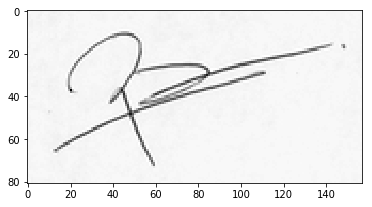

In [243]:
img = cv2.imread('data_1/genuine/005005_001.png',0)
plt.imshow(img,'gray')
plt.show()

This is the original signature(even though it is not my actual signature), we shall assume that this is the signature we are going to use is my original signature or the signature we need to verify.

## Gaussian Blurring and Otsu Thresholding for Binarization of the image

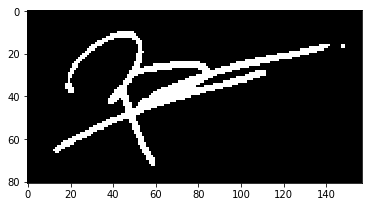

In [244]:
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image=np.invert(th3)
plt.imshow(image,'gray')
plt.show()

## Crop out the image needed

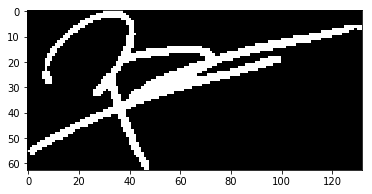

In [245]:
def crop_image(img,tol=0):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

cimg=crop_image(image,tol=0)
plt.imshow(cimg,'gray')
plt.show()

The parameters img and tol stand for the image data and tolerance of the image. Cropping out the image helps us extract essential details and discard the uneccessary pixels. 

## Performing thinning of the image

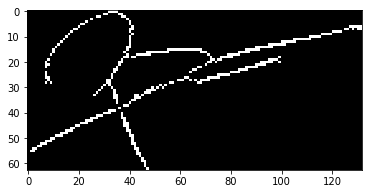

In [246]:
def thinning(img):
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
            
    return skel

timg=thinning(cimg)
plt.imshow(timg,'gray')
plt.show()

## Further Image Processing

In order to generate our dataset that we shall use to train our model so that it can recognise my original signature when a genuine signature is presented to it else regard it as forged. 

In [247]:
def preprocess_image(path, display=False):
    raw_image = cv2.imread(path)
    bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
    bw_image = 255 - bw_image

    if display:
        cv2.imshow("RGB to Gray", bw_image)
        cv2.waitKey()

    _, threshold_image = cv2.threshold(bw_image, 30, 255, 0)

    if display:
        cv2.imshow("Threshold", threshold_image)
        cv2.waitKey()

    return threshold_image

### Getting Contour Features

In [248]:
def get_contour_features(im, display=False):
    rect = cv2.minAreaRect(cv2.findNonZero(im))
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    w = np.linalg.norm(box[0] - box[1])
    h = np.linalg.norm(box[1] - box[2])

    aspect_ratio = max(w, h) / min(w, h)
    bounding_rect_area = w * h

    if display:
        image1 = cv2.drawContours(im.copy(), [box], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(image1, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    hull = cv2.convexHull(cv2.findNonZero(im))

    if display:
        convex_hull_image = cv2.drawContours(im.copy(), [hull], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(convex_hull_image, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    im2, contours, hierarchy = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if display:
        contour_image = cv2.drawContours(im.copy(), contours, -1, (120, 120, 120), 3)
        cv2.imshow("a", cv2.resize(contour_image, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    contour_area = 0
    for cnt in contours:
        contour_area += cv2.contourArea(cnt)
    hull_area = cv2.contourArea(hull)

    return aspect_ratio, bounding_rect_area, hull_area, contour_area
des_list = []

### SIFTing the Image

In [249]:
def sift(im, path, display=False):
    raw_image = cv2.imread(path)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(im, None)

    if display:
        cv2.drawKeypoints(im, kp, raw_image)
        cv2.imshow('sift_keypoints.jpg', cv2.resize(raw_image, (0, 0), fx=3, fy=3))
        cv2.waitKey()

    return (path, des)

### Training our model

In [264]:
genuine_image_filenames = listdir("data_1/genuine")
forged_image_filenames = listdir("data_1/forged")

genuine_image_paths = "data_1/genuine"
forged_image_paths = "data_1/forged"

genuine_image_features = [[] for x in range(12)]
forged_image_features = [[] for x in range(12)]

for name in genuine_image_filenames:
    signature_id = int(name.split('_')[0][-3:])
    genuine_image_features[signature_id - 1].append({"name": name})

for name in forged_image_filenames:
    signature_id = int(name.split('_')[0][-3:])
    forged_image_features[signature_id - 1].append({"name": name})


cor = 0
wrong = 0

im_contour_features = []
im_features = []

for i in range(12):
    des_list = []
    for im in genuine_image_features[i]:
        image_path = genuine_image_paths + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))


    for im in forged_image_features[i]:
        image_path = forged_image_paths + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))

    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    k = 120
    voc, variance = kmeans(descriptors, k, 1)

    # Calculate the histogram of features
   
    im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k+4), "float32")
    for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
        words, distance = vq(des_list[i][1], voc)
        for w in words:
            im_features[i][w] += 1

        for j in range(4):
            im_features[i][k+j] = im_contour_features[i][j]

    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)

    train_genuine_features, test_genuine_features = im_features[0:3], im_features[3:5]

    train_forged_features, test_forged_features = im_features[5:8], im_features[8:10]

 

    clf = LinearSVC()

    clf.fit(np.concatenate((train_forged_features,train_genuine_features)), np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))

    genuine_res = clf.predict(test_genuine_features)


    for res in genuine_res:
        if int(res) == 2:
            cor += 1
        else:
            wrong += 1

   
    forged_res = clf.predict(test_forged_features)


    for res in forged_res:
        if int(res) == 1:
            cor += 1
        else:
            wrong += 1 

print("Accuracy: ", float(cor)/(cor+wrong))
y_score = clf.decision_function(test_genuine_features)

('Accuracy: ', 0.9791666666666666)


## Doing Quick Testing to Explore the meaning of the accuracy

Let's define our testing function which would extract the features required from the test image

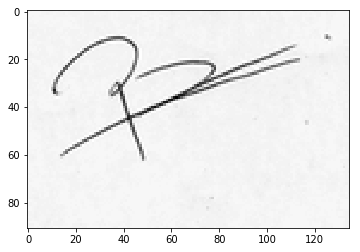

In [251]:
img = cv2.imread('data_1/testing/X.png',0)
plt.imshow(img,'gray')
plt.show()

This is a new genuine signature not used in the training dataset before. Let us first extract the required features from this picture. Starting with genuine features classification and define our test function. 

In [260]:
def test(image_path):
    genuine_image_filenames = listdir("data_1/genuine")
    forged_image_filenames = listdir("data_1/forged")

    genuine_image_paths = "data_1/genuine"
    forged_image_paths = "data_1/forged"

    genuine_image_features = [[] for x in range(12)]
    forged_image_features = [[] for x in range(12)]

    for name in genuine_image_filenames:
        signature_id = int(name.split('_')[0][-3:])
        genuine_image_features[signature_id - 1].append({"name": name})

    for name in forged_image_filenames:
        signature_id = int(name.split('_')[0][-3:])
        forged_image_features[signature_id - 1].append({"name": name})


    cor = 0
    wrong = 0

    im_contour_features = []
    im_features = []

    for i in range(12):
        des_list = []
        for im in genuine_image_features[i]:
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
                get_contour_features(preprocessed_image.copy(), display=False)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area

            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))


        for im in forged_image_features[i]:
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
                get_contour_features(preprocessed_image.copy(), display=False)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area

            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))

        descriptors = des_list[0][1]
        for image_path, descriptor in des_list[1:]:
            descriptors = np.vstack((descriptors, descriptor))
        k = 120
        voc, variance = kmeans(descriptors, k, 1)

        # Calculate the histogram of features

        im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k+4), "float32")
        for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
            words, distance = vq(des_list[i][1], voc)
            for w in words:
                im_features[i][w] += 1

            for j in range(4):
                im_features[i][k+j] = im_contour_features[i][j]

        #nbr_occurences = np.sum((im_features > 0) * 1, axis=0)
        #idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

        # Scaling the words
        stdSlr = StandardScaler().fit(im_features)
        im_features = stdSlr.transform(im_features)

        train_genuine_features, test_genuine_features = im_features[0:3], im_features[3:5]

        train_forged_features, test_forged_features = im_features[5:8], im_features[8:10]

        #clf = linear_model.LogisticRegression(C=1e5)

        clf = LinearSVC()
        #clf = tree.DecisionTreeClassifier()
        #clf = tree.DecisionTreeRegressor()
        #clf = svm.SVC()
        clf.fit(np.concatenate((train_forged_features,train_genuine_features)), np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))

        #print("2" + str(clf.predict(test_genuine_features)))
        genuine_res = clf.predict(test_genuine_features)


        for res in genuine_res:
            if int(res) == 2:
                return "Genuine"
            else:
                return "Forged"

    



In [261]:
image_path = "data_1/testing/X.png"
test(image_path)

'Genuine'

In [262]:
image_path = "data_1/testing/Y.png"
test(image_path)

'Forged'

In [263]:
image_path = "data_1/testing/Z.png"
test(image_path)

'Forged'

As you can see, the first image was the genuine replica of the test image and we have received Genuine while they next one was a random image so it claimed it to be forged image and the third one was a forged attempt so it has been classified as forged anyway.